# Третья часть проекта - распознавание лиц

## Установка пакетов и импорт библиотек

In [2]:
!pip install -q torchsummary

In [3]:
import os
import re
from itertools import combinations
import zipfile
from IPython.display import clear_output
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import time
from tqdm import tqdm
from PIL import Image
import warnings
warnings.filterwarnings("ignore")
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time
from skimage.io import imread
from matplotlib import rcParams
rcParams['figure.figsize'] = (15,4)
from collections import defaultdict
import torch
import cv2
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
import torchvision
from skimage.transform import resize
from torchvision.transforms import v2 as T
from torchsummary import summary
from torchvision.utils import save_image

from matplotlib import pyplot as plt
from torchvision.io import read_image, ImageReadMode

from torchvision.models import resnet18, ResNet18_Weights, resnet50, ResNet50_Weights, densenet121, DenseNet121_Weights
from torchvision.models.resnet import ResNet, BasicBlock

import math
import seaborn as sns

%matplotlib inline

sns.set(style='darkgrid', font_scale=1.2)
plt.ion()

In [4]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [5]:
try:
    dataDir = 'data/celebA_train_500/'
    with open(dataDir + 'celebA_anno.txt') as fid:
        labels = sorted(fid.read().split('\n'))
    print('Using local storage')
except:
    for dirname, _, filenames in os.walk('/kaggle/input'):
        print(os.path.join(dirname))
    dataDir = '/kaggle/input/celeba-500/celebA_train_500/'
    outDir = '/kaggle/working/'

/kaggle/input
/kaggle/input/for-metric
/kaggle/input/for-metric/celebA_ir
/kaggle/input/for-metric/celebA_ir/celebA_query
/kaggle/input/for-metric/celebA_ir/celebA_distractors
/kaggle/input/celeba-500
/kaggle/input/celeba-500/celebA_train_500
/kaggle/input/celeba-500/celebA_train_500/celebA_imgs


In [6]:
BATCH_SIZE = 64
IMG_SIZE = 128

generator = torch.Generator().manual_seed(1001)

## Загрузка аннотаций CelebA

In [7]:
with open(dataDir + 'celebA_anno.txt') as fid:
    labels = sorted(fid.read().split('\n'))
labels.pop(0) # first element is empty string
images = list(map(lambda x: x.split()[0], labels))
marks = list(map(lambda x: int(x.split()[1]), labels))

In [8]:
with open(dataDir + 'celebA_train_split.txt') as fid:
    splitter = sorted(fid.read().split('\n'))
splitter.pop(0) # first element is empty string
splitter = list(map(lambda x: int(x.split()[1]), splitter))

In [9]:
# imgs = list(sorted(os.listdir(os.path.join(dataDir, "celebA_train_500/celebA_imgs"))))

In [10]:
annotations = pd.concat([pd.Series(images), pd.Series(marks), pd.Series(splitter)], axis=1)
annotations = annotations.rename(columns={0: 'image', 1: 'label', 2: 'split'})
annotations['label'] = annotations['label'].astype('int32')
annotations['split'] = annotations['split'].astype('int32')
annotations.head()

,image,label,split
0,000001.jpg,0,0
1,000002.jpg,1,0
2,000003.jpg,2,0
3,000004.jpg,3,0
4,000005.jpg,4,0


In [11]:
annotations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12011 entries, 0 to 12010
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   12011 non-null  object
 1   label   12011 non-null  int32 
 2   split   12011 non-null  int32 
dtypes: int32(2), object(1)
memory usage: 187.8+ KB


In [12]:
print(f'train size {len(annotations.loc[annotations["split"]==0])}')
print(f'valid size {len(annotations.loc[annotations["split"]==1])}')
print(f'test size {len(annotations.loc[annotations["split"]==2])}')
print(f'labeled people {annotations["label"].nunique()}')

train size 8544
valid size 1878
test size 1589
labeled people 500


In [13]:
annotations.loc[annotations['split']==0].to_csv(outDir + 'train.csv')
annotations.loc[annotations['split']==1].to_csv(outDir + 'valid.csv')
annotations.loc[annotations['split']==2].to_csv(outDir + 'test.csv')
annotations.loc[annotations['split']==999].to_csv(outDir + 'other.csv')

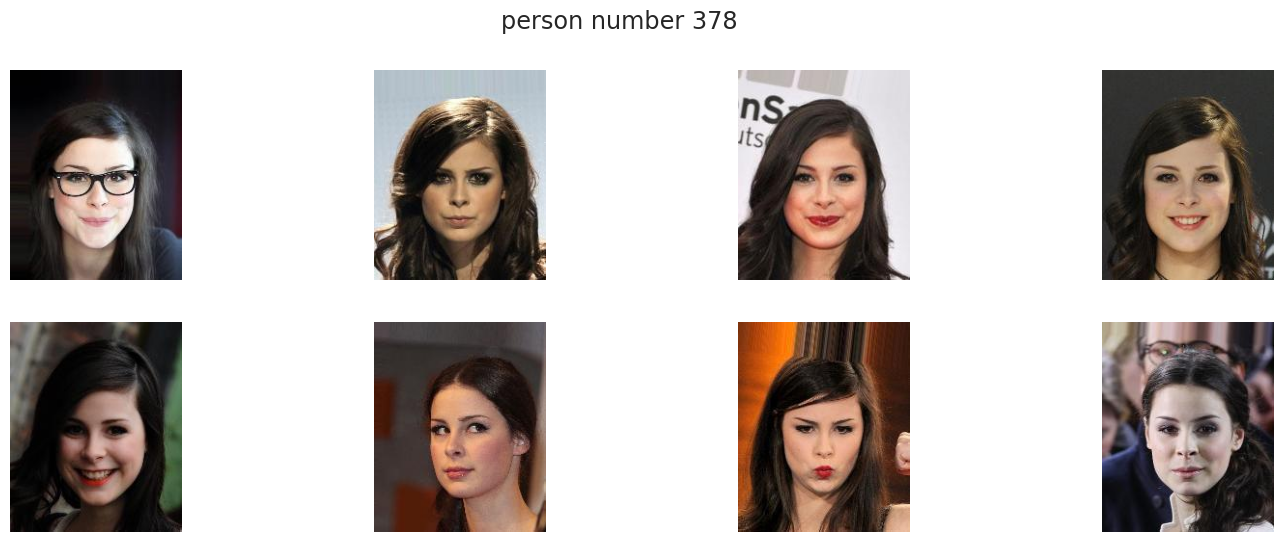

In [14]:
numb = np.random.randint(0, 500, 1)[0]
one_person = annotations.loc[annotations['label'] == numb][:8]
one_person = one_person['image'].reset_index(drop=True)
plt.figure(figsize=(18, 6))
for i in range(8):
    path = dataDir + 'celebA_imgs/' + one_person[i]
    plt.subplot(2, 4, i+1)
    plt.suptitle(f'person number {numb}')
    plt.axis("off")
    plt.imshow(Image.open(path))
plt.show();

## Трансформации и аугментации

In [15]:
transformer = transforms.Compose([
    transforms.ToTensor(),
#     transforms.Pad(padding=(70, 62), fill=0),
    transforms.CenterCrop((IMG_SIZE, IMG_SIZE)),
#     transforms.RandomSolarize(.8, p=.5),
#     transforms.RandomAdjustSharpness(2.0, .5)
    ])

## Класс датасета и даталоадеры

In [16]:
class FaceDataset(torch.utils.data.Dataset):
    def __init__(self, root, annotations, transform):
        self.root = root
        self.annotations = annotations
        self.imgs = list(self.annotations['image'])
        self.targets = list(self.annotations['label'])
        self.transforms = transform

    def __getitem__(self, idx):
        # load images and labels
        img_path = os.path.join(self.root, self.imgs[idx])
        img = np.array(Image.open(img_path))
        img = Image.fromarray(img[77:-41, 45:-50]) # hint img[77:-41, 45:-50]
        target = self.targets[idx]

        return self.transforms(img), torch.tensor(target)

    def __len__(self):
        return len(self.imgs)

In [17]:
train = pd.read_csv(outDir + 'train.csv')
valid = pd.read_csv(outDir + 'valid.csv')
test = pd.read_csv(outDir + 'test.csv')

In [18]:
faces_train = FaceDataset(dataDir + "celebA_imgs/", train, transform=transformer)
faces_valid = FaceDataset(dataDir + "celebA_imgs/", valid, transform=transformer)
faces_test = FaceDataset(dataDir + "celebA_imgs/", test, transform=transformer)

In [19]:
train_dataloader = torch.utils.data.DataLoader(faces_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
valid_dataloader = torch.utils.data.DataLoader(faces_valid, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
test_dataloader = torch.utils.data.DataLoader(faces_test, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

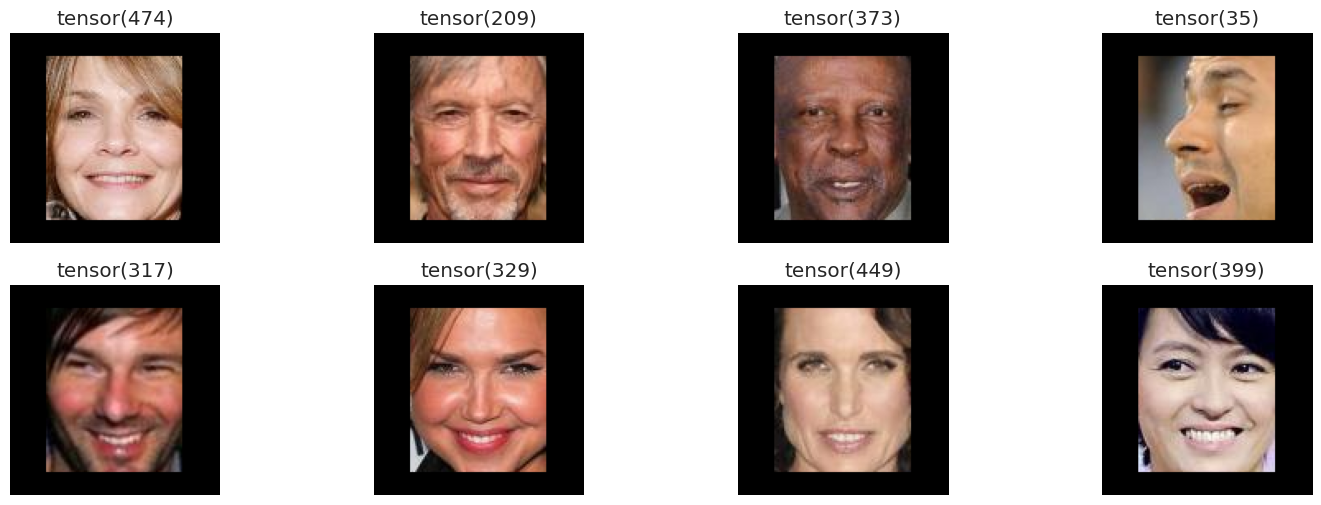

In [20]:
look = next(iter(train_dataloader))
plt.figure(figsize=(18, 6))
for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.axis("off")
    plt.imshow(look[0][i].permute(1,2,0))
    plt.title(look[1][i])
plt.show();

## Функции потерь и функции для обучения

In [21]:
def fit_epoch(model, train_loader, criterion, optimizer, scheduler_down, scheduler_up):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0

    for inputs, labels in train_loader:

        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)

    scheduler_down.step()
    scheduler_up.step()
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    rate = optimizer.param_groups[0]["lr"]
    print(f'learning rate -- {rate:.2}')
    return train_loss, train_acc, rate

In [22]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.cpu().numpy() / processed_size
    return val_loss, val_acc

In [23]:
def trainer(train, val, model, epochs, rate, criterion):

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.Adam(model.parameters(), lr=rate)
        sch_down = lr_scheduler.StepLR(opt, step_size=5, gamma=0.1)
        sch_up = lr_scheduler.StepLR(opt, step_size=10, gamma=200)
#         sch = torch.optim.lr_scheduler.CyclicLR(opt, base_lr=0.0003, max_lr=0.1,step_size_up=5,mode="triangular2", cycle_momentum=False)

        for epoch in range(epochs):
            train_loss, train_acc, rate = fit_epoch(model, train, criterion, opt, sch_down, sch_up)
#             print("loss", train_loss)

            val_loss, val_acc = eval_epoch(model, val, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc, rate))

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))

    return history

## Загрузка предобученной модели

### Склад использованных моделей

In [24]:
# weights = ResNet18_Weights.DEFAULT
# resnet = resnet18(weights=weights)

# # Set requires_grad = False for all parameters
# for param in resnet.parameters():
#     param.requires_grad = False

# layers = list(resnet.children())
# for layer in layers[-6:]:
#     for param in layer.parameters():
#         param.requires_grad = True
# in_features = 512
# out_features = 500
# resnet.fc = nn.Linear(in_features, out_features)
# resnet = resnet.to(device)
# # summary(resnet, (3,IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE)
# weights = ResNet50_Weights.DEFAULT
# resnet5 = resnet50(weights=weights)

# # Set requires_grad = False for all parameters
# for param in resnet5.parameters():
#     param.requires_grad = False

# layers = list(resnet5.children())
# for layer in layers[-10:]:
#     for param in layer.parameters():
#         param.requires_grad = True
# in_features = 2048
# out_features = 500
# resnet5.fc = nn.Linear(in_features, out_features)
# resnet5 = resnet5.to(device)
# # summary(resnet5, (3,IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE)
# mobilenet = models.mobilenet_v2(pretrained=True)
# mobilenet.classifier = nn.Sequential(nn.Dropout(p=0.2, inplace=False),
#                   nn.Linear(in_features=mobilenet.classifier[1].in_features, out_features=500, bias=True))
# mobilenet = mobilenet.to(device)

### Inception (need different format for outputs and Img Size 300 min): 
# otputs, _ = model(inputs)

# inception = models.inception_v3(pretrained=True)
# inception.fc =  nn.Linear(in_features=inception.fc.in_features, out_features=500, bias=True)
# inception = inception.to(device)

# enet = models.efficientnet_b0(pretrained=True)
# enet.classifier = nn.Sequential(nn.Dropout(p=0.2, inplace=False),
#                   nn.Linear(in_features=enet.classifier[1].in_features, out_features=500, bias=True))
# enet = enet.to(device)

### DenseNet 121 с заморозкой слоев

In [25]:
weights = DenseNet121_Weights.DEFAULT
dnet = densenet121(weights=weights)
layers = list(dnet.children())
for layer in layers[-8:]:
    for param in layer.parameters():
        param.requires_grad = True
in_features = 1024
out_features = 500
dnet.classifier = nn.Linear(in_features, out_features)
dnet = dnet.to(device)

# summary(dnet, (3,IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE)

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 52.7MB/s]


In [26]:
ce = nn.CrossEntropyLoss()
lr = 3e-4

In [27]:
history_2 = trainer(train_dataloader, valid_dataloader, model=dnet, epochs=30, rate=lr, criterion=ce)

epoch:   0%|          | 0/30 [00:00<?, ?it/s]

learning rate -- 0.0003


epoch:   3%|▎         | 1/30 [01:29<43:29, 89.98s/it]


Epoch 001 train_loss: 5.5760     val_loss 4.4890 train_acc 0.0646 val_acc 0.1672
learning rate -- 0.0003


epoch:   7%|▋         | 2/30 [02:15<29:41, 63.64s/it]


Epoch 002 train_loss: 3.5553     val_loss 3.3030 train_acc 0.3581 val_acc 0.3658
learning rate -- 0.0003


epoch:  10%|█         | 3/30 [03:02<25:15, 56.14s/it]


Epoch 003 train_loss: 2.1125     val_loss 2.4703 train_acc 0.6574 val_acc 0.5075
learning rate -- 0.0003


epoch:  13%|█▎        | 4/30 [03:49<22:45, 52.54s/it]


Epoch 004 train_loss: 1.0930     val_loss 1.9991 train_acc 0.8619 val_acc 0.5953
learning rate -- 3e-05


epoch:  17%|█▋        | 5/30 [04:35<20:55, 50.23s/it]


Epoch 005 train_loss: 0.4553     val_loss 1.8416 train_acc 0.9669 val_acc 0.6203
learning rate -- 3e-05


epoch:  20%|██        | 6/30 [05:21<19:31, 48.81s/it]


Epoch 006 train_loss: 0.1551     val_loss 1.4262 train_acc 0.9972 val_acc 0.7082
learning rate -- 3e-05


epoch:  23%|██▎       | 7/30 [06:07<18:19, 47.81s/it]


Epoch 007 train_loss: 0.1070     val_loss 1.4017 train_acc 0.9991 val_acc 0.7146
learning rate -- 3e-05


epoch:  27%|██▋       | 8/30 [06:54<17:23, 47.44s/it]


Epoch 008 train_loss: 0.0878     val_loss 1.3766 train_acc 0.9994 val_acc 0.7157
learning rate -- 3e-05


epoch:  30%|███       | 9/30 [07:39<16:25, 46.93s/it]


Epoch 009 train_loss: 0.0768     val_loss 1.3728 train_acc 0.9998 val_acc 0.7157
learning rate -- 0.0006


epoch:  33%|███▎      | 10/30 [08:25<15:30, 46.54s/it]


Epoch 010 train_loss: 0.0681     val_loss 1.3591 train_acc 0.9995 val_acc 0.7146
learning rate -- 0.0006


epoch:  37%|███▋      | 11/30 [09:11<14:39, 46.32s/it]


Epoch 011 train_loss: 1.0387     val_loss 3.5612 train_acc 0.7694 val_acc 0.2710
learning rate -- 0.0006


epoch:  40%|████      | 12/30 [09:56<13:49, 46.10s/it]


Epoch 012 train_loss: 1.1811     val_loss 2.1797 train_acc 0.7148 val_acc 0.5160
learning rate -- 0.0006


epoch:  43%|████▎     | 13/30 [10:42<13:00, 45.91s/it]


Epoch 013 train_loss: 0.3590     val_loss 1.7083 train_acc 0.9257 val_acc 0.6198
learning rate -- 0.0006


epoch:  47%|████▋     | 14/30 [11:27<12:12, 45.81s/it]


Epoch 014 train_loss: 0.0912     val_loss 1.3187 train_acc 0.9874 val_acc 0.7151
learning rate -- 6e-05


epoch:  50%|█████     | 15/30 [12:13<11:26, 45.77s/it]


Epoch 015 train_loss: 0.0237     val_loss 1.0469 train_acc 0.9987 val_acc 0.7705
learning rate -- 6e-05


epoch:  53%|█████▎    | 16/30 [12:59<10:40, 45.75s/it]


Epoch 016 train_loss: 0.0082     val_loss 1.0183 train_acc 0.9996 val_acc 0.7758
learning rate -- 6e-05


epoch:  57%|█████▋    | 17/30 [13:45<09:54, 45.76s/it]


Epoch 017 train_loss: 0.0069     val_loss 1.0127 train_acc 0.9998 val_acc 0.7774
learning rate -- 6e-05


epoch:  60%|██████    | 18/30 [14:31<09:10, 45.87s/it]


Epoch 018 train_loss: 0.0063     val_loss 1.0065 train_acc 0.9998 val_acc 0.7774
learning rate -- 6e-05


epoch:  63%|██████▎   | 19/30 [15:17<08:25, 45.96s/it]


Epoch 019 train_loss: 0.0059     val_loss 1.0037 train_acc 0.9999 val_acc 0.7769
learning rate -- 0.0012


epoch:  67%|██████▋   | 20/30 [16:03<07:39, 45.93s/it]


Epoch 020 train_loss: 0.0054     val_loss 0.9999 train_acc 1.0000 val_acc 0.7796
learning rate -- 0.0012


epoch:  70%|███████   | 21/30 [16:49<06:53, 45.97s/it]


Epoch 021 train_loss: 0.0112     val_loss 1.1759 train_acc 0.9993 val_acc 0.7396
learning rate -- 0.0012


epoch:  73%|███████▎  | 22/30 [17:35<06:07, 45.92s/it]


Epoch 022 train_loss: 0.6620     val_loss 9.8262 train_acc 0.8551 val_acc 0.0495
learning rate -- 0.0012


epoch:  77%|███████▋  | 23/30 [18:20<05:20, 45.75s/it]


Epoch 023 train_loss: 2.3596     val_loss 3.1657 train_acc 0.4610 val_acc 0.3775
learning rate -- 0.0012


epoch:  80%|████████  | 24/30 [19:06<04:35, 45.84s/it]


Epoch 024 train_loss: 0.7802     val_loss 2.1720 train_acc 0.7862 val_acc 0.5373
learning rate -- 0.00012


epoch:  83%|████████▎ | 25/30 [19:52<03:48, 45.77s/it]


Epoch 025 train_loss: 0.2640     val_loss 1.5475 train_acc 0.9294 val_acc 0.6794
learning rate -- 0.00012


epoch:  87%|████████▋ | 26/30 [20:38<03:03, 45.87s/it]


Epoch 026 train_loss: 0.0586     val_loss 1.0432 train_acc 0.9902 val_acc 0.7721
learning rate -- 0.00012


epoch:  90%|█████████ | 27/30 [21:24<02:17, 45.84s/it]


Epoch 027 train_loss: 0.0218     val_loss 1.0118 train_acc 0.9992 val_acc 0.7806
learning rate -- 0.00012


epoch:  93%|█████████▎| 28/30 [22:09<01:31, 45.69s/it]


Epoch 028 train_loss: 0.0155     val_loss 1.0023 train_acc 0.9998 val_acc 0.7833
learning rate -- 0.00012


epoch:  97%|█████████▋| 29/30 [22:54<00:45, 45.67s/it]


Epoch 029 train_loss: 0.0126     val_loss 0.9931 train_acc 0.9998 val_acc 0.7843
learning rate -- 0.0024


epoch: 100%|██████████| 30/30 [23:40<00:00, 47.35s/it]


Epoch 030 train_loss: 0.0106     val_loss 0.9872 train_acc 0.9999 val_acc 0.7891


In [28]:
def vizualize(h):
    loss, acc, val_loss, val_acc, rate = zip(*h)
    plt.figure(figsize=(15, 9))
    plt.plot(loss, label="train_loss")
    plt.plot(val_loss, label="val_loss")
    plt.legend(loc='best')
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.show()
    plt.plot(acc, label="train_accuracy")
    plt.plot(val_acc, label="validation_accuracy")
    plt.legend(loc='best')
    plt.xlabel("epochs")
    plt.ylabel("accuracy")
    plt.show()
    plt.plot(np.log(rate), label="learning_rate", color='green')
    plt.legend(loc='best')
    plt.xlabel("epochs")
    plt.ylabel("learning rate (log scale)")
    plt.show()

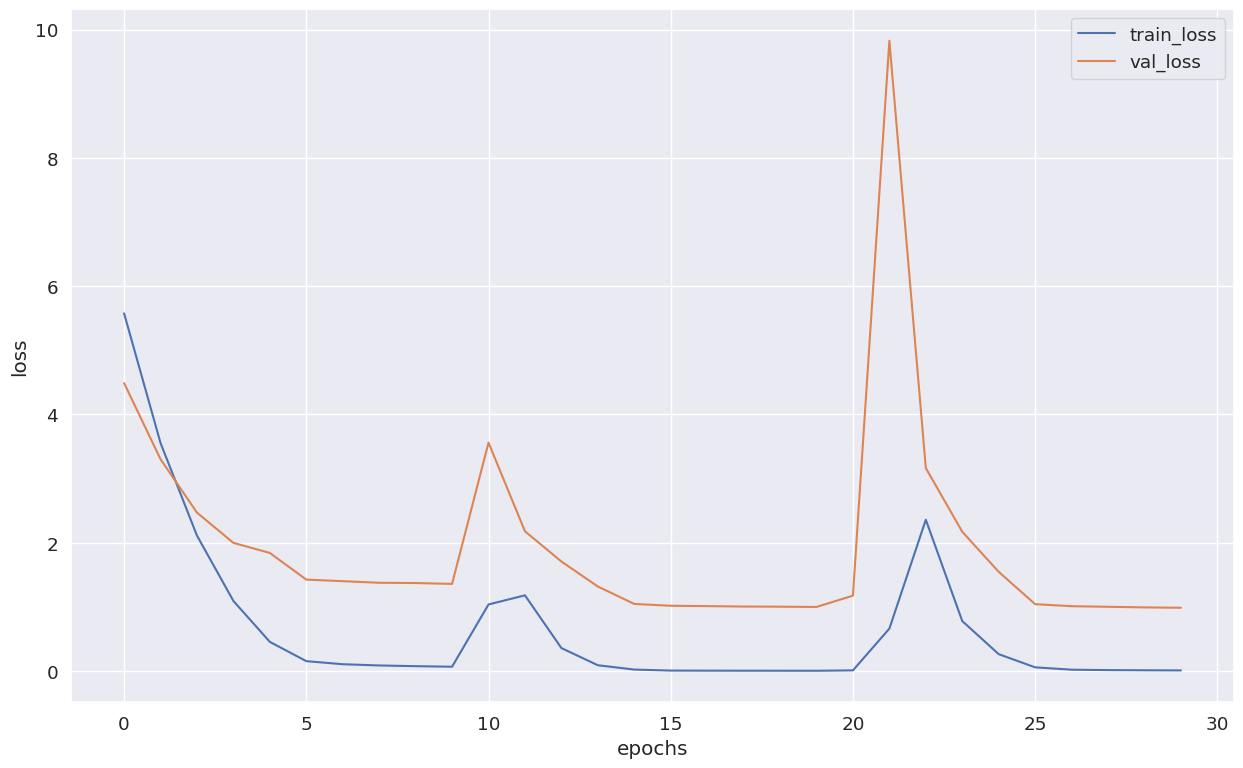

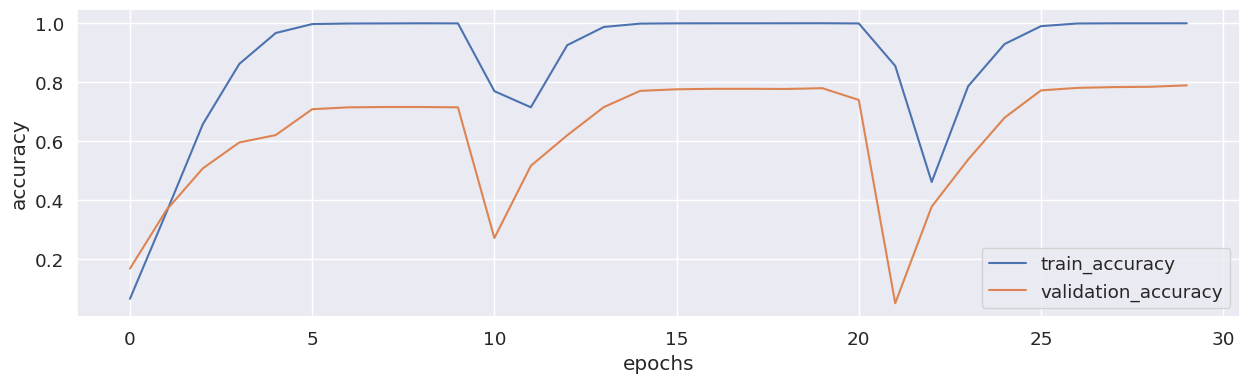

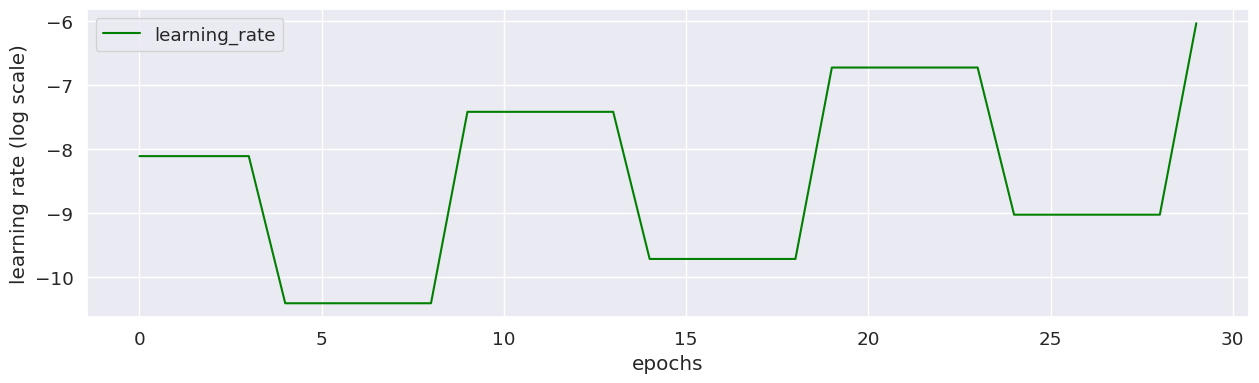

In [29]:
vizualize(history_2)

## Результаты для CrossEnthropyLoss

|**Модель**|**Число эпох**|**Accuracy на валидации**|
|--|--|--|
|ResNet18 без заморозки слоев|15|0,6|
|ResNet18 с заморозкой слоев|10|0,71|
|ResNet50 с заморозкой слоев|10|0,69|
|DenseNet121 с заморозкой слоев|15|0,75|
|**DenseNet121 с заморозкой слоев и двумя scheduler**|**30**|**0,79**|
|MobilenetV2|10|0,69|
|EfficientNet|15|0,67|


In [30]:
result = eval_epoch(dnet, test_dataloader, ce)
print(f'Test accuracy -- {result[1]:.2}')

Test accuracy -- 0.78


In [31]:
torch.cuda.empty_cache()

In [32]:
!mkdir /kaggle/working/result

In [33]:
torch.save(dnet.state_dict(), outDir + '/' + 'densenet.pth')

## TPR@FPR

### Загрузка query и distractors

In [34]:
tprDir = '/kaggle/input/for-metric/celebA_ir/'

In [35]:
with open(tprDir + 'celebA_anno_query.csv', 'r') as fid:
    query_lines = fid.readlines()[1:]
query_lines = [x.strip().split(',') for x in query_lines]
# plain list of image names from query. Neede to compute embeddings for query
query_img_names = [x[0] for x in query_lines]

# dictionary with info of which images from query belong to which class
# format:
#     {class: [image_1, image_2, ...]}
query_dict = defaultdict(list)
for img_name, img_class in query_lines:
    query_dict[img_class].append(img_name)

In [36]:
distractors_img_names = os.listdir(tprDir + 'celebA_distractors')

### Модель для эмбеддингов

In [37]:
emb_model = densenet121(weights=None)
in_features = 1024
out_features = 500
emb_model.classifier = nn.Linear(in_features, out_features)
emb_model = emb_model.to(device)
emb_model.load_state_dict(torch.load(outDir + '/' + 'densenet.pth'))

<All keys matched successfully>

In [38]:
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
        
    def forward(self, x):
        return x
emb_model.classifier = Identity()

In [39]:
face = next(iter(train_dataloader))[0][0]
e_output = emb_model(face.to(device).unsqueeze(0))
c_output = dnet(face.to(device).unsqueeze(0))
print(f'classifier shape - {c_output.shape}\nembedding shape - {e_output.shape}')

classifier shape - torch.Size([1, 500])
embedding shape - torch.Size([1, 1024])


## Эмбеддинги

Сперва посчитаем все эмбеддинги и запишем в словарь с именами соответствующих им изображений в качестве ключей. Для удобства расчета эмбеддингов сделан специальный датасет и даталоадер к нему

In [40]:
class AddFaceDataset(torch.utils.data.Dataset):
    def __init__(self, imgs, root, transform):
        self.root = root
        self.imgs = imgs
        self.transforms = transform
        self.names = os.listdir(self.root)

    def __getitem__(self, idx):
        # load images and labels
        img_path = os.path.join(self.root, self.imgs[idx])
        img = Image.open(img_path)
        name = self.names[idx]
        

        return self.transforms(img), name

    def __len__(self):
        return len(self.imgs)

In [41]:
query_data = AddFaceDataset(query_img_names, tprDir + 'celebA_query/',transformer)
distractor_data = AddFaceDataset(distractors_img_names, tprDir + 'celebA_distractors/',transformer)

In [42]:
def compute_embeddings(model, dataset):
    embs = []
    names = []
    loader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
    with torch.no_grad():
        for inputs, name in loader:
            inputs = inputs.to(device)
            model.eval()
            outputs = model(inputs)
            embs.append(outputs.cpu())
            for n in name:
                names.append(n)
    return torch.cat(embs), names

In [43]:
query_embeddings = {}
result = compute_embeddings(emb_model, query_data)
for i in range(len(result[0])):
    query_embeddings[result[1][i]] = result[0][i]

In [44]:
distractor_embeddings = {}
result = compute_embeddings(emb_model, distractor_data)
for i in range(len(result[0])):
    distractor_embeddings[result[1][i]] = result[0][i]

## Функции для расчета FPR и TPR

### Query-POS

In [45]:
def compute_cosine_query_pos(qd, qe):
    result = []
    cos = nn.CosineSimilarity(dim=0, eps=1e-6)
    for label in qd.keys():
        images = qd[label]
        for i, j in combinations(images, 2):
            result.append(float(cos(qe[i], qe[j])))
    return result

#### Test

In [46]:
test_query_dict = {
    2876: ['1.jpg', '2.jpg', '3.jpg'],
    5674: ['5.jpg'],
    864:  ['9.jpg', '10.jpg'],
}
test_query_embeddings = {
                    '1.jpg': torch.tensor([1.56, 6.45,  -7.68]),
                    '2.jpg': torch.tensor([-1.1 , 6.11,  -3.0]),
                    '3.jpg': torch.tensor([-0.06,-0.98,-1.29]),
                    '5.jpg': torch.tensor([8.56, 1.45,  1.11]),
                    '9.jpg': torch.tensor([0.7,  1.1,   -7.56]),
                    '10.jpg': torch.tensor([0.05, 0.9,   -2.56]),
}

In [47]:
test_cosine_query_pos = compute_cosine_query_pos(test_query_dict, test_query_embeddings)
true_cosine_query_pos = [0.8678237233650096, 0.21226104378511604,
                         -0.18355866977496182, 0.9787437979250561]
assert np.allclose(sorted(test_cosine_query_pos), sorted(true_cosine_query_pos)), \
      "A mistake in compute_cosine_query_pos function"

#### Compute

In [48]:
%%time
positive = compute_cosine_query_pos(query_dict, query_embeddings)

CPU times: user 445 ms, sys: 980 µs, total: 446 ms
Wall time: 445 ms


### Qery Neg

In [49]:
def compute_cosine_query_neg(qd, qe):
    result = []
    cos = nn.CosineSimilarity(dim=0, eps=1e-6)
    for cl, other_cl in combinations(qd.keys(), 2):
        images = qd[cl]
        other_images = qd[other_cl]
        for image in images:
            for other_image in other_images:
                result.append(float(cos(qe[image], qe[other_image])))
    return result

#### Test

In [50]:
test_cosine_query_neg = compute_cosine_query_neg(test_query_dict, test_query_embeddings)
true_cosine_query_neg = [0.15963231223161822, 0.8507997093616965, 0.9272761484302097,
                         -0.0643994061127092, 0.5412660901220571, 0.701307100338029,
                         -0.2372575528216902, 0.6941032794522218, 0.549425446066643,
                         -0.011982733001947084, -0.0466679194884999]
assert np.allclose(sorted(test_cosine_query_neg), sorted(true_cosine_query_neg)), \
      "A mistake in compute_cosine_query_neg function"

#### Compute

In [51]:
%%time
negative = compute_cosine_query_neg(query_dict, query_embeddings)

CPU times: user 22.9 s, sys: 19.2 ms, total: 22.9 s
Wall time: 22.9 s


### Distractors Neg

In [52]:
def compute_cosine_query_distractors(query_embeddings, distractor_embeddings):
    result = []
    cos = nn.CosineSimilarity(dim=0, eps=1e-6)
    for query in query_embeddings.values():
        for distr in distractor_embeddings.values():
            result.append(float(cos(query, distr)))
    return result

#### Test

In [53]:
test_distractors_img_names = ['11.jpg', '12.jpg', '13.jpg', '14.jpg', '15.jpg']

test_distractors_embeddings = {
                    '11.jpg': torch.tensor([0.12, -3.23, -5.55]),
                    '12.jpg': torch.tensor([-1,   -0.01, 1.22]),
                    '13.jpg': torch.tensor([0.06, -0.23, 1.34]),
                    '14.jpg': torch.tensor([-6.6, 1.45,  -1.45]),
                    '15.jpg': torch.tensor([0.89,  1.98, 1.45]),
}

In [54]:
test_cosine_query_distractors = compute_cosine_query_distractors(test_query_embeddings,
                                                            test_distractors_embeddings)
true_cosine_query_distractors = [0.3371426578637511, -0.6866465610863652, -0.8456563512871669,
                                 0.14530087113136106, 0.11410510307646118, -0.07265097629002357,
                                 -0.24097699660707042,-0.5851992679925766, 0.4295494455718534,
                                 0.37604478596058194, 0.9909483738948858, -0.5881093317868022,
                                 -0.6829712976642919, 0.07546364489032083, -0.9130970963915521,
                                 -0.17463101988684684, -0.5229363015558941, 0.1399896725311533,
                                 -0.9258034013399499, 0.5295114163723346, 0.7811585442749943,
                                 -0.8208760031249596, -0.9905139680301821, 0.14969764653247228,
                                 -0.40749654525418444, 0.648660814944824, -0.7432584300096284,
                                 -0.9839696492435877, 0.2498741082804709, -0.2661183373780491]
assert np.allclose(sorted(test_cosine_query_distractors), sorted(true_cosine_query_distractors)), \
      "A mistake in compute_cosine_query_distractors function"

#### Compute

In [55]:
%%time
query_distractors = compute_cosine_query_distractors(query_embeddings, distractor_embeddings)

CPU times: user 1min 14s, sys: 86.1 ms, total: 1min 14s
Wall time: 1min 14s


### TPR@FPR

In [56]:
def compute_ir(qpos: list, qneg: list, qd: list, fpr: float):
    false_pairs = sorted(qneg + qd)
    n = int(fpr * len(false_pairs))
    threshold = sorted(false_pairs, reverse=True)[n]
    counter = 0
    for q in qpos:
        if q > threshold:
            counter += 1
    return threshold, counter / len(qpos)

#### Test

In [57]:
test_thr = []
test_tpr = []
for fpr in [0.5, 0.3, 0.1]:
    x, y = compute_ir(test_cosine_query_pos, test_cosine_query_neg,
                    test_cosine_query_distractors, fpr=fpr)
    test_thr.append(x)
    test_tpr.append(y)

true_thr = [-0.011982733001947084, 0.3371426578637511, 0.701307100338029]
assert np.allclose(np.array(test_thr), np.array(true_thr)), "A mistake in computing threshold"

true_tpr = [0.75, 0.5, 0.5]
assert np.allclose(np.array(test_tpr), np.array(true_tpr)), "A mistake in computing tpr"

#### Compute

In [58]:
for fpr in [.5, .25, .1, .01]:
    print(f'threshold - {fpr} - metric - {compute_ir(positive, negative, query_distractors, fpr=fpr)[1]}')

threshold - 0.5 - metric - 0.5223150601181985
threshold - 0.25 - metric - 0.26750900074723183
threshold - 0.1 - metric - 0.11208477684939881
threshold - 0.01 - metric - 0.016642891107941038


### Результаты обучения на Cross-Enthropy Loss

- accuracy на тестовой выборке приближается к 80 %
- вместе с тем, TPR@FPR на неизвестных модели ранее изображениях при требуемом низком проценте ложно-положительных срабатываний достаточно невысок. 
- применительно к поставленной задаче (система распознавания лиц для контроля доступа на предприятие со сравнительно небольшим коллективом) кажется целесообразным измерять не только метрику на посторонних людях, но и на тех же самых сотрудниках в очках/шапке/с другой прической

## ArcFace Loss



In [59]:
weights = DenseNet121_Weights.DEFAULT
dnet = densenet121(weights=weights)
layers = list(dnet.children())
for layer in layers[-8:]:
    for param in layer.parameters():
        param.requires_grad = True
in_features = 1024
out_features = 500
dnet.classifier = nn.Linear(in_features, out_features)
dnet = dnet.to(device)

In [60]:
class ArcFaceLoss(nn.Module):
    def __init__(self, num_classes, embedding_size, margin, scale):
        
        super().__init__()
        self.num_classes = num_classes
        self.embedding_size = embedding_size
        self.margin = margin
        self.scale = scale
        
        self.W = torch.nn.Parameter(torch.Tensor(num_classes, embedding_size)).to(device)
        nn.init.xavier_normal_(self.W)
        
    def forward(self, embeddings, labels):

        cosine = self.get_cosine(embeddings) # (None, n_classes)
        mask = self.get_target_mask(labels) # (None, n_classes)
        cosine_of_target_classes = cosine[mask == 1] # (None, )
        modified_cosine_of_target_classes = self.modify_cosine_of_target_classes(
            cosine_of_target_classes
        ) # (None, )
        diff = (modified_cosine_of_target_classes - cosine_of_target_classes).unsqueeze(1) # (None,1)
        logits = cosine + (mask * diff) # (None, n_classes)
        logits = self.scale_logits(logits) # (None, n_classes)
        return nn.CrossEntropyLoss()(logits, labels)
        
    def get_cosine(self, embeddings):
        
        cosine = F.linear(F.normalize(embeddings), F.normalize(self.W))
        return cosine
    
    def get_target_mask(self, labels):
       
        batch_size = labels.size(0)
        onehot = torch.zeros(batch_size, self.num_classes, device=labels.device)
        onehot.scatter_(1, labels.unsqueeze(-1), 1)
        return onehot
        
    def modify_cosine_of_target_classes(self, cosine_of_target_classes):
     
        eps = 1e-6
        # theta in the paper
        angles = torch.acos(torch.clamp(cosine_of_target_classes, -1 + eps, 1 - eps))
        return torch.cos(angles + self.margin)
    
    def scale_logits(self, logits):
        
        return logits * self.scale

In [61]:
aloss = ArcFaceLoss(500, 500, .1, 16)

In [62]:
history_s = trainer(train_dataloader, valid_dataloader, model=dnet, epochs=10, rate=3e-4, criterion=aloss)

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

learning rate -- 0.0003


epoch:  10%|█         | 1/10 [00:47<07:09, 47.67s/it]


Epoch 001 train_loss: 7.2897     val_loss 6.4888 train_acc 0.0019 val_acc 0.0043
learning rate -- 0.0003


epoch:  20%|██        | 2/10 [01:34<06:17, 47.17s/it]


Epoch 002 train_loss: 5.5526     val_loss 5.3399 train_acc 0.0028 val_acc 0.0016
learning rate -- 0.0003


epoch:  30%|███       | 3/10 [02:21<05:29, 47.06s/it]


Epoch 003 train_loss: 4.0097     val_loss 4.8192 train_acc 0.0018 val_acc 0.0011
learning rate -- 0.0003


epoch:  40%|████      | 4/10 [03:08<04:41, 46.96s/it]


Epoch 004 train_loss: 2.6354     val_loss 3.9553 train_acc 0.0021 val_acc 0.0021
learning rate -- 3e-05


epoch:  50%|█████     | 5/10 [03:55<03:55, 47.08s/it]


Epoch 005 train_loss: 1.5246     val_loss 3.3509 train_acc 0.0016 val_acc 0.0011
learning rate -- 3e-05


epoch:  60%|██████    | 6/10 [04:42<03:07, 46.97s/it]


Epoch 006 train_loss: 0.6383     val_loss 2.7553 train_acc 0.0018 val_acc 0.0027
learning rate -- 3e-05


epoch:  70%|███████   | 7/10 [05:29<02:20, 46.97s/it]


Epoch 007 train_loss: 0.4558     val_loss 2.7031 train_acc 0.0022 val_acc 0.0027
learning rate -- 3e-05


epoch:  80%|████████  | 8/10 [06:15<01:33, 46.88s/it]


Epoch 008 train_loss: 0.3775     val_loss 2.6743 train_acc 0.0019 val_acc 0.0016
learning rate -- 3e-05


epoch:  90%|█████████ | 9/10 [07:02<00:46, 46.86s/it]


Epoch 009 train_loss: 0.3226     val_loss 2.6613 train_acc 0.0021 val_acc 0.0011
learning rate -- 0.0006


epoch: 100%|██████████| 10/10 [07:49<00:00, 46.98s/it]


Epoch 010 train_loss: 0.2797     val_loss 2.6341 train_acc 0.0022 val_acc 0.0016


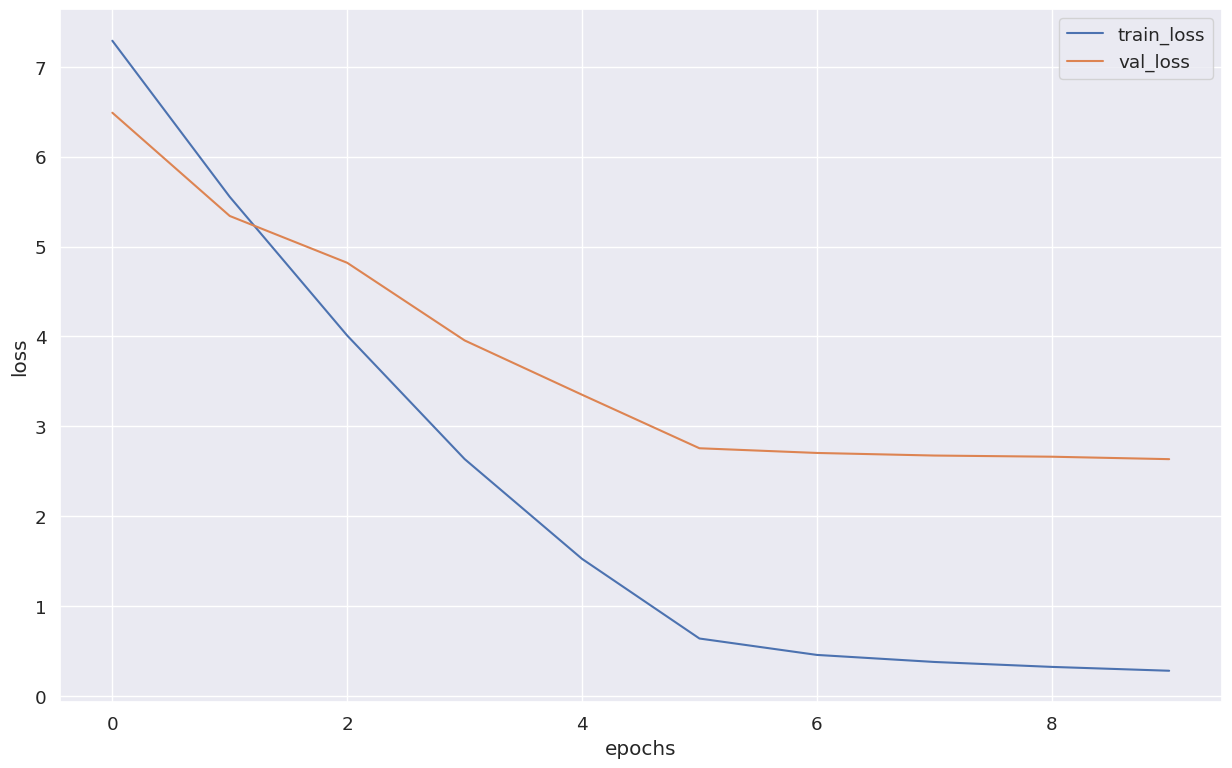

In [63]:
loss, acc, val_loss, val_acc, rate = zip(*history_s)
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

## Результаты

**TODO** - починить лосс и расчет accuracy

## Triplet Loss

### Датасет и даталоадер

Возвращают тройки (anchor-positive-negative) изображений и их метки

In [64]:
class Triplet(torch.utils.data.Dataset):
    def __init__(self, root, annotations, transform):
        self.root = root
        self.annotations = annotations
        self.imgs = list(self.annotations['image'])
        self.targets = list(self.annotations['label'])
        self.transforms = transform

    def __getitem__(self, idx):
        # load images and labels
        target = self.targets[idx]
        a = self.annotations.loc[self.annotations['label'] == target]['image'].values
        anchors = []
        positives = []
        negatives = []
        for a, p in combinations(a, 2):
            anchors.append(a)
            positives.append(p)
        neg_ind = self.annotations.loc[self.annotations['label'] != target]['image'].unique()
        ind = np.random.randint(0, len(neg_ind), len(anchors))
        for i in ind:
            negatives.append(self.annotations.loc[self.annotations['image'] == neg_ind[i]]['image'].values[0])
        for j in range(len(anchors)):
            a_path = os.path.join(self.root, anchors[j])
            p_path = os.path.join(self.root, positives[j])
            n_path = os.path.join(self.root, negatives[j])
            anc = np.array(Image.open(a_path))
            anc = Image.fromarray(anc[77:-41, 45:-50])
            pos = np.array(Image.open(p_path))
            pos = Image.fromarray(pos[77:-41, 45:-50])
            neg = np.array(Image.open(n_path))
            neg = Image.fromarray(neg[77:-41, 45:-50])
            a_target = self.annotations.loc[self.annotations['image'] == anchors[j]]['label'].values[0]
            p_target = self.annotations.loc[self.annotations['image'] == positives[j]]['label'].values[0]
            n_target = self.annotations.loc[self.annotations['image'] == negatives[j]]['label'].values[0]

            return self.transforms(anc), self.transforms(pos), self.transforms(neg), torch.tensor(a_target), torch.tensor(p_target), torch.tensor(n_target)

    def __len__(self):
        return len(self.imgs)

In [65]:
tri_train = Triplet(dataDir + "celebA_imgs/", train, transform=transformer)
tri_valid = Triplet(dataDir + "celebA_imgs/", valid, transform=transformer)
tri_test = Triplet(dataDir + "celebA_imgs/", test, transform=transformer)
tri_train_dataloader = torch.utils.data.DataLoader(tri_train, batch_size=2, shuffle=True, num_workers=0)
tri_valid_dataloader = torch.utils.data.DataLoader(tri_valid, batch_size=2, shuffle=True, num_workers=0)
tri_test_dataloader = torch.utils.data.DataLoader(tri_test, batch_size=2, shuffle=False, num_workers=0)

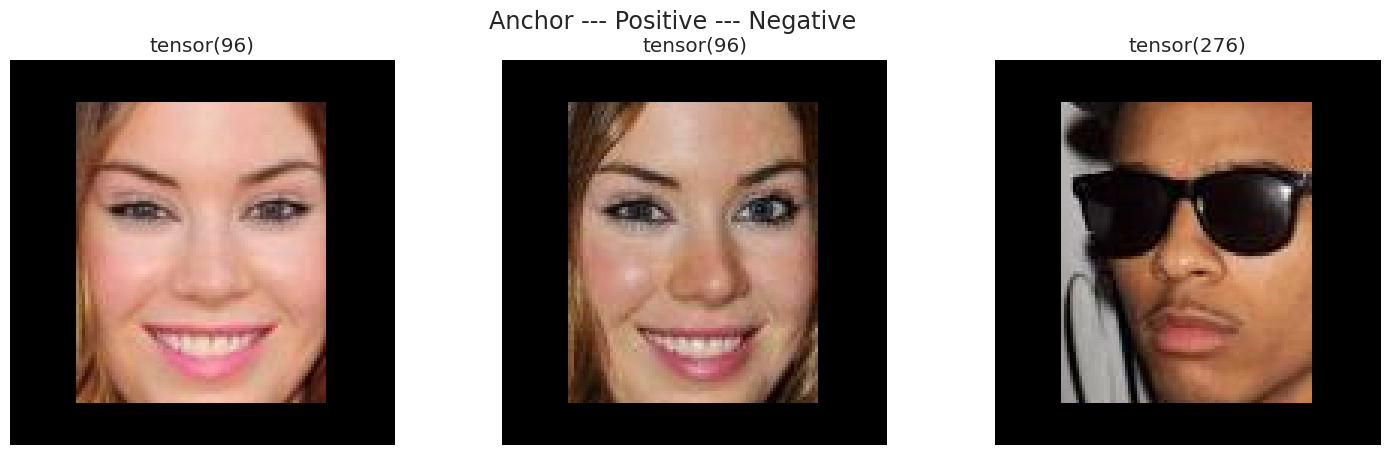

In [81]:
look = next(iter(tri_train_dataloader))
plt.figure(figsize=(18, 5))
for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.axis("off")
    plt.imshow(look[i][0].permute(1,2,0))
    plt.title(look[i+3][0])
plt.suptitle(f'Anchor --- Positive --- Negative\n')
plt.show();

## Адаптация модели

Теперь возьмем одну из сетей, которая использовалась ранее, и немного ее доработаем. Помимо выхода классификационного слоя (который понадобится для расчета accuracy) будет еще выход с предыдущего слоя эмбеддингов для расчета Triplet Loss

In [67]:
class MyResNet(ResNet):
    def __init__(self):
        super(MyResNet, self).__init__(BasicBlock, [2, 2, 2, 2])
        
    def _forward_impl(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x_1 = torch.flatten(x, 1)
        x = self.fc(x_1)

        return x, x_1

In [68]:
tri_model = MyResNet()
tri_model.load_state_dict(models.resnet18(pretrained=True).state_dict())

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 216MB/s] 


<All keys matched successfully>

In [69]:
for param in tri_model.parameters():
    param.requires_grad = False

layers = list(tri_model.children())
for layer in layers[-6:]:
    for param in layer.parameters():
        param.requires_grad = True
in_features = 512
out_features = 500
tri_model.fc = nn.Linear(in_features, out_features)
tri_model = tri_model.to(device)

In [70]:
out = tri_model(tri_train[0][0].unsqueeze(0).to(device))
print(f'embedder out - {out[1].shape}\nclassifier out - {out[0].shape}')

embedder out - torch.Size([1, 512])
classifier out - torch.Size([1, 500])


### Функции для обучения

In [71]:
def triloss(anchor, positive, negative, margin):
    a = nn.functional.normalize(anchor)
    p = nn.functional.normalize(positive)
    n = nn.functional.normalize(negative)
    cos = nn.CosineSimilarity(dim=1, eps=1e-6)
    res = torch.max((cos(a, p) - cos(a, n) + margin), 0)
    return torch.tensor(res[0]).requires_grad_()

In [72]:
def fit_epoch_t(model, train_loader, criterion, optimizer, scheduler_down):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0

    for a, p, n, ta, _, _ in train_loader:

        a = a.to(device)
        p = p.to(device)
        n = n.to(device)
        ta = ta.to(device)
        optimizer.zero_grad()

        aemb = model(a)[1]
        pemb = model(p)[1]
        nemb = model(n)[1]
        acl = model(a)[0]
        loss = criterion(aemb, pemb, nemb, MARGIN)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(acl, 1)
        running_loss += loss.item() * a.size(0)
        running_corrects += torch.sum(preds == ta.data)
        processed_data += a.size(0)

    scheduler_down.step()
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [73]:
def eval_epoch_t(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for a, p, n, ta, _, _ in val_loader:

        a = a.to(device)
        p = p.to(device)
        n = n.to(device)
        ta = ta.to(device)

        with torch.set_grad_enabled(False):
            aemb = model(a)[1]
            pemb = model(p)[1]
            nemb = model(n)[1]
            acl = model(a)[0]
            loss = criterion(aemb, pemb, nemb, MARGIN)
            preds = torch.argmax(acl, 1)

        running_loss += loss.item() * a.size(0)
        running_corrects += torch.sum(preds == ta.data)
        processed_data += a.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.cpu().numpy() / processed_size
    return val_loss, val_acc

In [74]:
def trainer_t(train, val, model, epochs, rate, criterion):

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.Adam(model.parameters(), lr=rate)
        sch_down = lr_scheduler.StepLR(opt, step_size=5, gamma=0.1)
    
        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch_t(model, train, criterion, opt, sch_down)


            val_loss, val_acc = eval_epoch_t(model, val, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc, rate))

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))

    return history

In [75]:
lr = 3e-3
MARGIN = .1

In [ ]:
history_t = trainer_t(tri_train_dataloader, tri_valid_dataloader, model=tri_model, epochs=10, rate=lr, criterion=triloss)

# Результаты

**Было реализовано:**
- обучение модели определения лиц на Cross Enthropy Loss. Accuracy - 0,8
- рассчитана TPR@FPR - до 0,52
- реализованы функции для обучения на ArcFace, но не подобраны параметры обучения
- реализован загрузчик anchor-negative-positive изображений для triplet loss, но не подобраны гиперпараметры для обучения